# 决策树简介

# 熵
+ 表示随机变量的不确定性  
$H(p)=-\sum_{i=1}^{n} p_{i} \log p_{i}$
+ 熵越大，随机变量的不确定性越大！！

# 熵的计算
$H(p)=-\sum_{i=1}^{n} p_{i} \log p_{i}$  
$H(D)=-\sum_{k=1}^{k} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$

# 条件熵
定义如下：
$H(Y \mid X)=\sum_{i=1}^{n} p_{i} H\left(Y \mid X=x_{i}\right)$  
其中 $p_{i}=P\left(X=x_{i}\right)$    

---
$H(D \mid A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{D \mid} H\left(D_{i}\right)$  
$=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{D \mid} \sum_{k=1}^{K} \frac{\left|D_{ik}\right|}{D_{i} \mid} \log _{2} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|}$

# 信息增益  
+ 定义  
信息增益（也叫互信息），定义如下：  
$g(D,A) = H(D)-H(D|A)$  其中D是训练数据集，A是某个特征
+ 根据信息增益准则的特征选择方法是：
    1. 对训练数据集（或子集）D， 计算其中每个特征的洗洗增益
    2. 比较他们的大小，选择信息增益最大的特征
+ 信息增益法
    1. 计算数据集D的经验熵$H(D)$:   
    $H(D)=-\sum_{k=1}^{k} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$
    2. 计算特征A对数据集的经验条件熵$H(D|A)$  
    $H(D \mid A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \sum_{k=1}^{k} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|} \log _{2} \frac{\left|D_{ik}\right|}{\left|D_{i}\right|}$
    3. 计算信息增益   
    $g(D,A) = H(D)-H(D|A)$


+ 例子  
![](./img/4_1.png)

+ ID3算法： 在决策树递归构建过程中，使用信息增益的方法进行特征选择
+ 决策树生成过程：  
 1. 从根节点开始计算所有特征的信息增益，选择信息增益最大的特征作为结点特征
 2. 再对子节点递归以上的方法，构建决策树
 3. 所有特征信息增益很小或没有特征可以选择时递归结束得到一颗决策树

# ID3代码实现
![](./img/4_2.png)

In [1]:
def loaddata():
    feature_name = ['age','job','house','credit']
    dataSet = [[0, 0,0,0, 'no'],
               [0, 0,0,1,'no'],
               [0, 1,0,1, 'yes'],
               [0, 1,1,0, 'yes'],
               [0, 0,0,0, 'no'],
               [1, 0,0,0, 'no'],
               [1, 0,0,1, 'no'],
               [1, 1,1,1, 'yes'],
               [1, 0,1,2, 'yes'],
               [1, 0,1,2, 'yes'],
               [2, 0,1,2, 'yes'],
               [2, 0,1,1, 'yes'],
               [2, 1,0,1, 'yes'],
               [2, 1,0,2, 'yes'],
               [2, 0,0,0,'no']]
    
    return dataSet, feature_name
datas, features = loaddata()
datas[:3]

[[0, 0, 0, 0, 'no'], [0, 0, 0, 1, 'no'], [0, 1, 0, 1, 'yes']]

In [18]:
from scipy import math
def entropy(datas):
    entropy_ = 0
    label_counts = {}
    goaldata = [d[-1] for d in datas]
    length = len(datas)
    for d in goaldata:
        label_counts[d] = label_counts.get(d, 0) + 1
    
    for k, v in label_counts.items():
        p = v / length
        e_ = - p * math.log2(p)
        entropy_ += e_
    return entropy_

def feature_entropy(datas, axis):
    all_length = len(datas)
    feature_entropy = 0
    discounts = set([d[axis] for d in datas])
    for dis in discounts:
        data = [d for d in datas if d[axis] == dis]
        data_length = len(data)
        e = (data_length / all_length) * entropy(data)
        feature_entropy += e
    return feature_entropy

def choose_best_feature(datas, features):
    
    all_e = entropy(datas)
    info_gain = []
    for idx, feature in enumerate(features):
        feature_e = feature_entropy(datas, idx)
        diff = all_e - feature_e
        info_gain.append(diff)
    
    max_ = max(info_gain)
    idx = info_gain.index(max_)
    feature = features[idx]
#     print(datas, features, info_gain)
    return idx, feature
    

#划分数据集
def split_dataset(datas, axis, value):
    ret_dataset = [d[0:axis] + d[axis+1:] for d in datas if d[axis] == value]
    return ret_dataset

def class_vote(class_list):
    class_set = set(class_list)
    class_count = {c: class_list.count(c) for c in class_set}
    class_count = sorted(class_count.items(), key=lambda d: d[1], reverse=True)
    return class_count[0][0]

def train_tree(datas, features):
    classlist = [d[-1] for d in datas]
    if len(set(classlist)) == 1: #就剩下一个类别
        return classlist[0]
    if len(datas[0]) == 2: #就剩下一个特征
        return class_vote(classlist)
    bestidx, bestfeature = choose_best_feature(datas, features)
    my_tree = {bestfeature:{}}
    sub_features = [f for f in features if f != bestfeature]
    best_datas = [d[bestidx] for d in datas]
    for value in set(best_datas):
        sub_datas = split_dataset(datas, bestidx, value)
        my_tree[bestfeature][value] = train_tree(sub_datas, sub_features)
    return my_tree
        

In [20]:
datas, features = loaddata()
mytree = train_tree(datas, features)
print(mytree)

{'house': {0: {'job': {0: 'no', 1: 'yes'}}, 1: 'yes'}}


In [21]:
mytree.keys()

dict_keys(['house'])

In [43]:
def predict(mytree, features, testdata):
    firstkey = list(mytree.keys())[0]
    subtree = mytree.get(firstkey)
    idx = features.index(firstkey)
    dv = testdata[idx]
    subtree = subtree.get(dv)
    if isinstance(subtree, dict):
        classlabel = predict(subtree, features, testdata)
    else:
        classlabel = subtree
        
    return classlabel
        

In [44]:
predict(mytree, features, [1, 1, 0, 1])

'yes'

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

array(['yes'], dtype='<U3')

[Text(200.88000000000002, 181.2, 'house <= 0.5\ngini = 0.48\nsamples = 15\nvalue = [6, 9]'),
 Text(133.92000000000002, 108.72, 'job <= 0.5\ngini = 0.444\nsamples = 9\nvalue = [6, 3]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

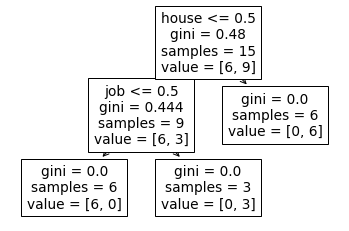

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc = DecisionTreeClassifier()
X = np.array([d[:-1] for d in datas])
y = np.array([d[-1] for d in datas]).reshape(-1, 1)
dtc.fit(X, y)
dtc.predict([[1, 1, 0, 1]])
plot_tree(dtc, feature_names=features)

# C4.5算法

C4.5是对ID3的改进， 在树的生成过程中，使用信息增益比来选择特征  
ID3计算信息增益的公式：$g(D,A)=H(D)-H(D|A)$  
C4.5计算信息增益比公式：  
$g_{R}(D, A)=\frac{g(D, A)}{H_{A}(D)}$  
其中$H_{A}(D)=-\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} \log _{2} \frac{\left|D_{i}\right|}{|D|}$

# Gini指数

CART算法：在树生成过程中，使用基尼指数选择最优特征。征程的是二叉树。  
1. 设样本点属于第K累的概率为$p_k$, 则$Gini(p)=\sum_{k=1}^{k}p_k(1-p_k)=1-\sum_{k=1}^{k}p_k^2$   
2. 给定样本集合D， 起基尼指数为： $\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{|C_{k} \mid}{|D|}\right)^{2}$  
3. 在特定A的条件下，集合D的基尼指数为：$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}(D 1)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}(D 2)$  
基尼指数越大，样本你的不确定性越大，这点与熵相似。